In [1]:
import sys
sys.path.append("models/raster")
sys.path.append("models/vector")
sys.path.append("models/multimodal")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from auxiliary.visualization import visualize_losses, visualize_multiple_losses, visualize_confusion_matrix
from auxiliary.misc import send_notification, get_model_name

from initialize_gnn import initialize_gnn
from dataset_vector import get_dummy_sample
from cnn import CNN
from vit import ViT

from dataset_multimodal import BuildingMultimodalDataset
from model_multimodal import MultimodalModel
from train_multimodal import train_multimodal_model
from metrics_multimodal import get_metrics_multimodal
from predict_multimodal import get_activations_multimodal

from models.pr_roc import get_pr_roc, plot_pr_curve, plot_roc_curve

In [2]:
# defining a seed for reproducible results
np.random.seed(69)

In [3]:
# Check if CUDA is available, then MPS, otherwise use CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()
    # cluster path
    raster_path = "../scratch/raster"
    vector_path = "../scratch/vector"
    multimodal_path = "../scratch/multimodal"
else:
    device = torch.device("cpu")
    # local path
    raster_path = "../data.nosync/raster"
    vector_path = "../data.nosync/vector"
    multimodal_path = "../data.nosync/multimodal"

print(f"Device set to: {device}")

Device set to: cpu


In [4]:
# operators are always specified in this order
operator_order = ("elimination", "aggregation", "typification", "displacement", "enlargement", "simplification")
# features are always specified in this order
feature_order = ("area", 
                 "perimeter", 
                 "convexity", 
                 "eri", 
                 "orientation_mbr", 
                 "wall_average", 
                 "voronoi_area", 
                 "impact_area", 
                 "x_coord", 
                 "y_coord")

In [5]:
# Define DIN font for plots if working locally
if not torch.cuda.is_available():
    plt.rcParams["font.family"] = "DIN Alternate"

## Elimination model

### Data loading

In [6]:
# define path to training, validation and test data for both raster and vector
path_to_raster_training_data = os.path.join(raster_path, "training_data", "elimination", "training")
path_to_vector_training_data = os.path.join(vector_path, "training_data", "elimination", "training")
path_to_raster_validation_data = os.path.join(raster_path, "training_data", "elimination", "validation")
path_to_vector_validation_data = os.path.join(vector_path, "training_data", "elimination", "validation")
path_to_raster_test_data = os.path.join(raster_path, "training_data", "elimination", "test")
path_to_vector_test_data = os.path.join(vector_path, "training_data", "elimination", "test")

# define input parameters
elimination_operators = ["elimination"]
features = ["area", 
            "perimeter", 
            "convexity", 
            "eri", 
            "orientation_mbr", 
            "wall_average", 
            "voronoi_area", 
            "impact_area", 
            "x_coord", 
            "y_coord"]
n_classes = len(elimination_operators)

# load dummy sample
dummy_sample_path = os.path.join(vector_path, "training_data", "dummy_sample.pt")
dummy_sample = get_dummy_sample(dummy_sample_path, 
                                operators=elimination_operators, 
                                operator_order=operator_order,
                                features=features, 
                                feature_order=feature_order,
                                attach_roads=True)

# subset of the data to use for prototyping purposes
subset = 1000

# construct training Dataset
training_set = BuildingMultimodalDataset(path_to_raster_training_data, 
                                         path_to_vector_training_data, 
                                         operators=elimination_operators,
                                         operator_order=operator_order,
                                         features=features,
                                         feature_order=feature_order,
                                         attach_roads=True,
                                         raster_transform=None,
                                         vector_transform=None,
                                         subset=subset)

# construct validation Dataset (no shuffling)
validation_set = BuildingMultimodalDataset(path_to_raster_validation_data, 
                                           path_to_vector_validation_data, 
                                           operators=elimination_operators,
                                           operator_order=operator_order,
                                           features=features,
                                           feature_order=feature_order,
                                           attach_roads=True,
                                           raster_transform=None,
                                           vector_transform=None,
                                           subset=subset)

# construct test Dataset (no shuffling)
test_set = BuildingMultimodalDataset(path_to_raster_test_data, 
                                     path_to_vector_test_data, 
                                     operators=elimination_operators,
                                     operator_order=operator_order,
                                     features=features,
                                     feature_order=feature_order,
                                     attach_roads=True,
                                     raster_transform=None,
                                     vector_transform=None,
                                     subset=subset)

print(f"{len(training_set):,} samples in the training set.")
print(f"{len(validation_set):,} samples in the validation set.")
print(f"{len(test_set):,} samples in the test set.")

1,000 samples in the training set.
1,000 samples in the validation set.
1,000 samples in the test set.


### Setup

In [7]:
# number of epochs and batch size
n_epochs = 10
batch_size = 16

# load the trained raster model
raster_model_path = os.path.join(raster_path, "models", "elimination")
raster_model_name = "CNN_eli_attachRoadsTrue_4075585p_1000s_10ep_bs16.pth"
raster_model = CNN(n_channels=3, n_classes=1)
#raster_model_name = "ViT_eli_attachRoadsTrue_26820129p_1000s_10ep_bs16.pth"
#raster_model = ViT(channels=3, num_classes=1)
raster_checkpoint = torch.load(os.path.join(raster_model_path, raster_model_name), map_location=device)
raster_model.load_state_dict(raster_checkpoint["model_state_dict"])
raster_model.eval()
    
# load the trained vector model
vector_model_path = os.path.join(vector_path, "models", "elimination")
#vector_model_name = "HGNN_eli_attachRoadsTrue_253313p_1000s_10ep_bs16.pth"
#vector_model = initialize_gnn(model="hgnn", sample=dummy_sample, hidden_channels=128, num_layers=3, node_to_predict="focal_building")
vector_model_name = "HGT_eli_attachRoadsTrue_700466p_1000s_10ep_bs64.pth"
vector_model = initialize_gnn(model="hgt", sample=dummy_sample, hidden_channels=128, num_heads=8, 
                              num_layers=3, node_to_predict="focal_building")
vector_checkpoint = torch.load(os.path.join(vector_model_path, vector_model_name), map_location=device)
vector_model.load_state_dict(vector_checkpoint["model_state_dict"])
vector_model.eval()

print("Models successfully loaded.")

Number of node features: {'focal_building': 10, 'context_building': 10, 'road': 2}, 1 operators
Models successfully loaded.


In [8]:
# initialize the multimodal model
model = MultimodalModel(raster_model, 
                        vector_model, 
                        dummy_raster_sample=training_set[0][0], 
                        dummy_vector_sample=dummy_sample, 
                        n_classes=n_classes)

model.to(device)

learning_rate = 0.0005
criterion = nn.BCEWithLogitsLoss() # Binary cross-entropy loss, applies a sigmoid internally and takes logits as input
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(model)

Multimodal Model with 4,775,794 parameters consisting of
        raster model (CNN) with 2,469,696 parameters and 
        vector model (HGT) with 683,825 parameters.


### Model training

In [9]:
# training the model
model, training_losses, validation_losses, training_time = train_multimodal_model(model=model, 
                                                                                  device=device, 
                                                                                  optimizer=optimizer, 
                                                                                  criterion=criterion, 
                                                                                  n_epochs=n_epochs, 
                                                                                  batch_size=batch_size, 
                                                                                  validate=True, 
                                                                                  training_set=training_set, 
                                                                                  validation_set=validation_set, 
                                                                                  shuffle_training_set=True, 
                                                                                  shuffle_validation_set=False)

# saving the losses
model_name = get_model_name(model, 
                            ops="eli", 
                            attach_roads=True, 
                            n_samples=len(training_set), 
                            n_epochs=n_epochs, 
                            batch_size=batch_size,
                            device=device) + ".csv"
losses_path = os.path.join(multimodal_path, "model_outputs", "elimination", "losses", model_name)

# creating a DataFrame with loss values
losses_df = pd.DataFrame({"epoch": list(range(1, n_epochs+1)), 
                          "training_loss": training_losses, 
                          "validation_loss": validation_losses})

# save to CSV
losses_df.to_csv(losses_path, index=False)

# if working on ScienceCluster, send notification that training has finished
if torch.cuda.is_available():
    send_notification(model=model, 
                      email_address="joris.senn@uzh.ch", 
                      n_samples=len(training_set), 
                      n_epochs=n_epochs, 
                      batch_size=batch_size, 
                      time=training_time)

# save the trained model to disk
path_to_models = os.path.join(multimodal_path, "models", "elimination")

model_name = get_model_name(model, 
                            ops="eli", 
                            attach_roads=True, 
                            n_samples=len(training_set), 
                            n_epochs=n_epochs, 
                            batch_size=batch_size,
                            device=device) + ".pth"

torch.save({"epoch": n_epochs,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": criterion,
            }, os.path.join(path_to_models, model_name))

epoch 1/10, step 6/63
epoch 1/10, step 12/63
epoch 1/10, step 18/63
epoch 1/10, step 24/63
epoch 1/10, step 30/63
epoch 1/10, step 36/63
epoch 1/10, step 42/63
epoch 1/10, step 48/63
epoch 1/10, step 54/63
epoch 1/10, step 60/63
epoch 1 finished, training loss: 0.652, validation loss: 0.633
epoch 2/10, step 6/63
epoch 2/10, step 12/63
epoch 2/10, step 18/63
epoch 2/10, step 24/63
epoch 2/10, step 30/63
epoch 2/10, step 36/63
epoch 2/10, step 42/63
epoch 2/10, step 48/63
epoch 2/10, step 54/63
epoch 2/10, step 60/63
epoch 2 finished, training loss: 0.637, validation loss: 0.634
epoch 3/10, step 6/63
epoch 3/10, step 12/63
epoch 3/10, step 18/63
epoch 3/10, step 24/63
epoch 3/10, step 30/63
epoch 3/10, step 36/63
epoch 3/10, step 42/63
epoch 3/10, step 48/63
epoch 3/10, step 54/63
epoch 3/10, step 60/63
epoch 3 finished, training loss: 0.636, validation loss: 0.636
epoch 4/10, step 6/63
epoch 4/10, step 12/63
epoch 4/10, step 18/63
epoch 4/10, step 24/63
epoch 4/10, step 30/63
epoch 4/10

### Loss curves

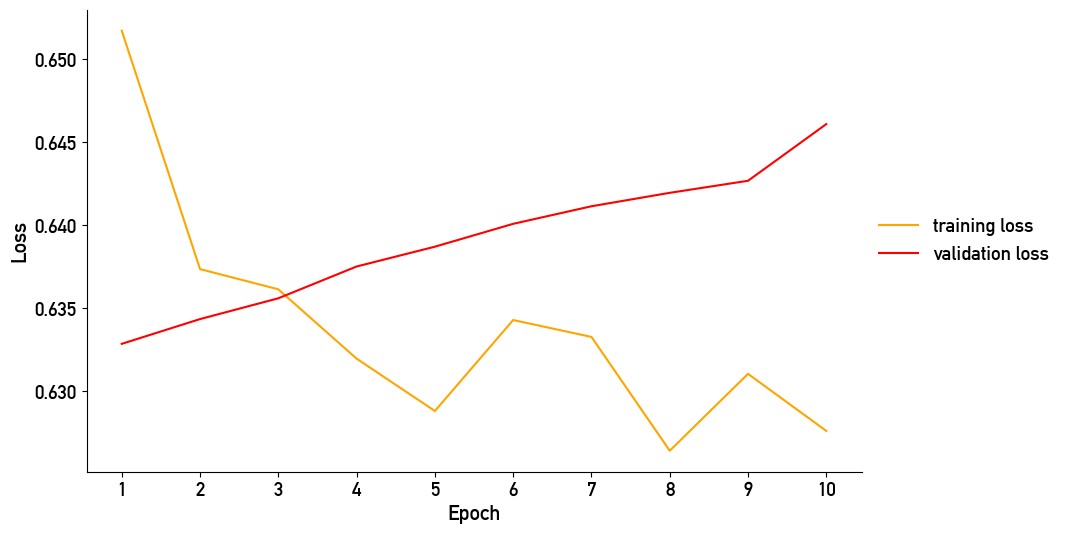

In [10]:
loss_path = os.path.join(multimodal_path, "model_outputs", "elimination", "losses")
visualize_losses(model_name, loss_path)

### Loading the trained model

In [12]:
# load the trained raster models
raster_model_path = os.path.join(raster_path, "models", "elimination")

#raster_model_name = "CNN_eli_attachRoadsTrue_4075585p_1000s_10ep_bs16.pth"
raster_model = CNN(n_channels=3, n_classes=1)
raster_checkpoint = torch.load(os.path.join(raster_model_path, raster_model_name), map_location=device)
raster_model.load_state_dict(raster_checkpoint["model_state_dict"])
raster_model.eval()

# load the trained vector models
vector_model_path = os.path.join(vector_path, "models", "elimination")

#vector_model_name = "HGT_eli_attachRoadsTrue_645539p_1000s_10ep_bs16.pth"
vector_model = initialize_gnn(model="hgt", 
                              sample=dummy_sample, 
                              hidden_channels=128, 
                              num_heads=8,
                              num_layers=3, 
                              node_to_predict="focal_building")
vector_checkpoint = torch.load(os.path.join(vector_model_path, vector_model_name), map_location=device)
vector_model.load_state_dict(vector_checkpoint["model_state_dict"])
vector_model.eval()

# load the trained multimodal model
model_path = os.path.join(multimodal_path, "models", "elimination")

#model_name = "MultimodalCNNHGT_eli_attachRoadsTrue_4720867p_1000s_10ep_bs16.pth"
model = MultimodalModel(raster_model=raster_model, 
                        vector_model=vector_model, 
                        dummy_raster_sample=training_set[1][0], 
                        dummy_vector_sample=dummy_sample, 
                        n_classes=1)
checkpoint = torch.load(os.path.join(model_path, model_name), map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print("Model successfully loaded.")

Number of node features: {'focal_building': 10, 'context_building': 10, 'road': 2}, 1 operators
Model successfully loaded.


### ROC and PR curves

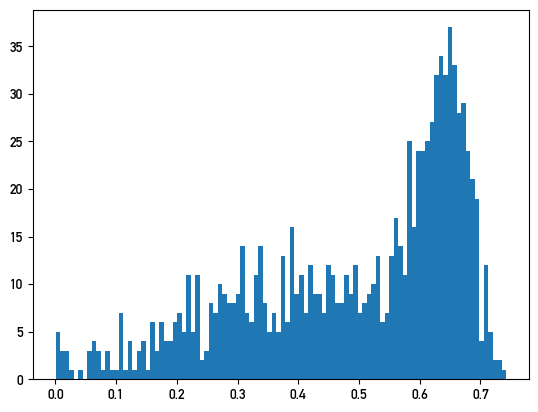

In [13]:
activations = get_activations_multimodal(model, 
                                         dataset=validation_set, 
                                         batch_size=len(validation_set), 
                                         operators_to_pred=elimination_operators, 
                                         device=device)

plt.hist(activations, bins=100)
plt.show()

In [14]:
# get precision-recall and ROC values for different thresholds
pr_roc = get_pr_roc(model=model, 
                    dataset=validation_set, 
                    batch_size=len(validation_set), 
                    operators_to_pred=elimination_operators, 
                    device=device, 
                    interval=(0,1), 
                    increment=0.1)

# save the PR and ROC values
model_name = get_model_name(model, 
                            ops="eli", 
                            attach_roads=True, 
                            n_samples=len(training_set), 
                            n_epochs=n_epochs, 
                            batch_size=batch_size,
                            device=device) + ".csv"
pr_roc_path = os.path.join(multimodal_path, "model_outputs", "elimination", "pr_roc", model_name)
pr_roc.to_csv(pr_roc_path, index=False)

/Library/anaconda3/envs/genops/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/anaconda3/envs/genops/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


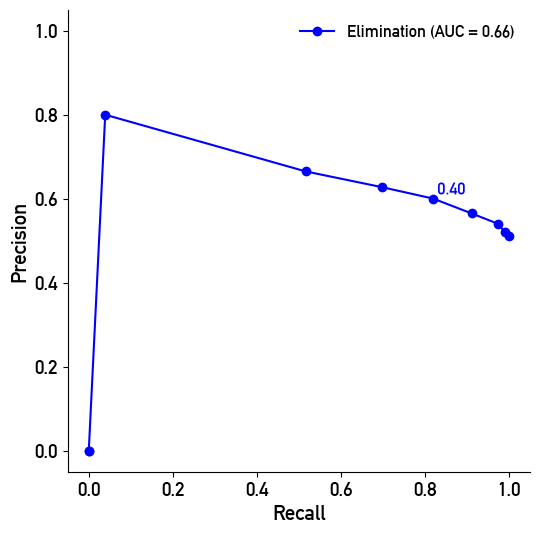

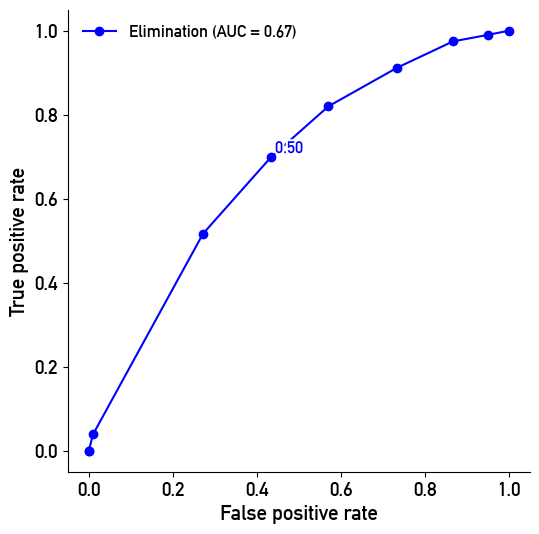

In [15]:
# plot the curves
plot_pr_curve([pr_roc_path], threshold_labels=True)
plot_roc_curve([pr_roc_path], threshold_labels=True)

### Accuracy metrics

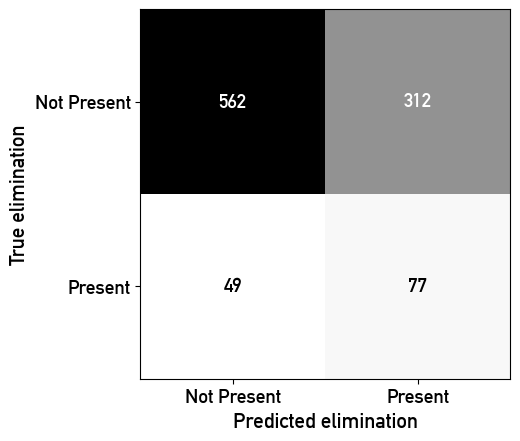

Accuracy: 0.639
Precision: 0.198
Recall: 0.611
F1 Score: 0.299


In [16]:
# calculate accuracy metrics
metrics = get_metrics_multimodal(model=model, 
                                 dataset=test_set,
                                 batch_size=len(test_set),
                                 operators_to_pred=elimination_operators, 
                                 threshold=0.5, 
                                 device=device)

# saving the accuracy metrics
model_name = get_model_name(model, 
                            ops="eli", 
                            attach_roads=True, 
                            n_samples=len(training_set), 
                            n_epochs=n_epochs, 
                            batch_size=batch_size,
                            device=device) + ".csv"
metrics_path = os.path.join(multimodal_path, "model_outputs", "elimination", "metrics", model_name)

# creating a DataFrame with accuracy metrics
metrics_df = pd.DataFrame({"operator": metrics["operator"],
                           "accuracy": metrics["accuracy"], 
                           "precision": metrics["precision"],
                           "recall": metrics["recall"],
                           "f1-score": metrics["f1_score"]})

# save to CSV
metrics_df.to_csv(metrics_path, index=False)

# print the results
for i in range(len(elimination_operators)):
    # display the confusion matrix
    visualize_confusion_matrix(metrics["conf_matrix"][i], operator=metrics["operator"][i])

    # print metrics
    print(f"Accuracy: {metrics['accuracy'][i]:.3f}")
    print(f"Precision: {metrics['precision'][i]:.3f}")
    print(f"Recall: {metrics['recall'][i]:.3f}")
    print(f"F1 Score: {metrics['f1_score'][i]:.3f}")

## Selection model

### Data loading

In [17]:
# define path to training, validation and test data for both raster and vector
path_to_raster_training_data = os.path.join(raster_path, "training_data", "selection", "training")
path_to_vector_training_data = os.path.join(vector_path, "training_data", "selection", "training")
path_to_raster_validation_data = os.path.join(raster_path, "training_data", "selection", "validation")
path_to_vector_validation_data = os.path.join(vector_path, "training_data", "selection", "validation")
path_to_raster_test_data = os.path.join(raster_path, "training_data", "selection", "test")
path_to_vector_test_data = os.path.join(vector_path, "training_data", "selection", "test")

# define input parameters
selection_operators = ["aggregation", "typification", "displacement", "enlargement"]
features = ["area", 
            "perimeter", 
            "convexity", 
            "eri", 
            "orientation_mbr", 
            "wall_average", 
            "voronoi_area", 
            "impact_area", 
            "x_coord", 
            "y_coord"]
n_classes = len(selection_operators)

# load dummy sample
dummy_sample_path = os.path.join(vector_path, "training_data", "dummy_sample.pt")
dummy_sample = get_dummy_sample(dummy_sample_path, 
                                operators=selection_operators, 
                                operator_order=operator_order,
                                features=features, 
                                feature_order=feature_order,
                                attach_roads=True)

# subset of the data to use for prototyping purposes
subset = 1000

# construct training Dataset
training_set = BuildingMultimodalDataset(path_to_raster_training_data, 
                                         path_to_vector_training_data, 
                                         operators=selection_operators,
                                         operator_order=operator_order,
                                         features=features,
                                         feature_order=feature_order,
                                         attach_roads=True,
                                         raster_transform=None,
                                         vector_transform=None,
                                         subset=subset)

# construct validation Dataset (no shuffling)
validation_set = BuildingMultimodalDataset(path_to_raster_validation_data,
                                           path_to_vector_validation_data,
                                           operators=selection_operators,
                                           operator_order=operator_order,
                                           features=features,
                                           feature_order=feature_order,
                                           attach_roads=True,
                                           raster_transform=None,
                                           vector_transform=None,
                                           subset=subset)

# construct test Dataset (no shuffling)
test_set = BuildingMultimodalDataset(path_to_raster_test_data,
                                     path_to_vector_test_data,
                                     operators=selection_operators,
                                     operator_order=operator_order,
                                     features=features,
                                     feature_order=feature_order,
                                     attach_roads=True,
                                     raster_transform=None,
                                     vector_transform=None,
                                     subset=subset)

print(f"{len(training_set):,} samples in the training set.")
print(f"{len(validation_set):,} samples in the validation set.")
print(f"{len(test_set):,} samples in the test set.")

1,000 samples in the training set.
1,000 samples in the validation set.
1,000 samples in the test set.


### Setup

In [18]:
# number of epochs and batch size
n_epochs = 10
batch_size = 16

# load the trained raster model
raster_model_path = os.path.join(raster_path, "models", "selection")
raster_model_name = "CNN_sel_attachRoadsTrue_8893252p_1000s_10ep_bs16.pth"
raster_model = CNN(n_channels=3, n_classes=4)
#raster_model_name = "ViT_sel_attachRoadsTrue_26844804p_1000s_10ep_bs16.pth"
#raster_model = ViT(channels=3, num_classes=4)
raster_checkpoint = torch.load(os.path.join(raster_model_path, raster_model_name), map_location=device)
raster_model.load_state_dict(raster_checkpoint["model_state_dict"])
raster_model.eval()
    
# load the trained vector model
vector_model_path = os.path.join(vector_path, "models", "selection")
#vector_model_name = "HGNN_sel_attachRoadsTrue_278276p_1000s_10ep_bs16.pth"
#vector_model = initialize_gnn(model="hgnn", sample=dummy_sample, hidden_channels=128, num_layers=3, node_to_predict="focal_building")
vector_model_name = "HGT_sel_attachRoadsTrue_750389p_1000s_10ep_bs64.pth"
vector_model = initialize_gnn(model="hgt", sample=dummy_sample, hidden_channels=128, num_heads=8, 
                              num_layers=3, node_to_predict="focal_building")
vector_checkpoint = torch.load(os.path.join(vector_model_path, vector_model_name), map_location=device)
vector_model.load_state_dict(vector_checkpoint["model_state_dict"])
vector_model.eval()

print("Models successfully loaded.")

Number of node features: {'focal_building': 10, 'context_building': 10, 'road': 2}, 4 operators
Models successfully loaded.


In [19]:
# initialize the multimodal model
model = MultimodalModel(raster_model, 
                        vector_model, 
                        dummy_raster_sample=training_set[0][0], 
                        dummy_vector_sample=dummy_sample, 
                        n_classes=n_classes)

model.to(device)

learning_rate = 0.0005
criterion = nn.BCEWithLogitsLoss() # Binary cross-entropy loss, applies a sigmoid internally and takes logits as input
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(model)

Multimodal Model with 9,642,613 parameters consisting of
        raster model (CNN) with 2,469,696 parameters and 
        vector model (HGT) with 683,825 parameters.


### Model training

In [20]:
# training the model
model, training_losses, validation_losses, training_time = train_multimodal_model(model=model, 
                                                                                  device=device, 
                                                                                  optimizer=optimizer, 
                                                                                  criterion=criterion, 
                                                                                  n_epochs=n_epochs, 
                                                                                  batch_size=batch_size, 
                                                                                  validate=True, 
                                                                                  training_set=training_set, 
                                                                                  validation_set=validation_set, 
                                                                                  shuffle_training_set=True, 
                                                                                  shuffle_validation_set=False)

# saving the losses
model_name = get_model_name(model, 
                            ops="sel", 
                            attach_roads=True, 
                            n_samples=len(training_set), 
                            n_epochs=n_epochs, 
                            batch_size=batch_size,
                            device=device) + ".csv"
losses_path = os.path.join(multimodal_path, "model_outputs", "selection", "losses", model_name)

# creating a DataFrame with loss values
losses_df = pd.DataFrame({"epoch": list(range(1, n_epochs+1)), 
                          "training_loss": training_losses, 
                          "validation_loss": validation_losses})

# save to CSV
losses_df.to_csv(losses_path, index=False)

# if working on ScienceCluster, send notification that training has finished
if torch.cuda.is_available():
    send_notification(model=model, 
                      email_address="joris.senn@uzh.ch", 
                      n_samples=len(training_set), 
                      n_epochs=n_epochs, 
                      batch_size=batch_size, 
                      time=training_time)

# save the trained model to disk
path_to_models = os.path.join(multimodal_path, "models", "selection")

model_name = get_model_name(model, 
                            ops="sel", 
                            attach_roads=True, 
                            n_samples=len(training_set), 
                            n_epochs=n_epochs, 
                            batch_size=batch_size,
                            device=device) + ".pth"

torch.save({"epoch": n_epochs,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": criterion,
            }, os.path.join(path_to_models, model_name))

epoch 1/10, step 6/63
epoch 1/10, step 12/63
epoch 1/10, step 18/63
epoch 1/10, step 24/63
epoch 1/10, step 30/63
epoch 1/10, step 36/63
epoch 1/10, step 42/63
epoch 1/10, step 48/63
epoch 1/10, step 54/63
epoch 1/10, step 60/63
epoch 1 finished, training loss: 0.635, validation loss: 0.616
epoch 2/10, step 6/63
epoch 2/10, step 12/63
epoch 2/10, step 18/63
epoch 2/10, step 24/63
epoch 2/10, step 30/63
epoch 2/10, step 36/63
epoch 2/10, step 42/63
epoch 2/10, step 48/63
epoch 2/10, step 54/63
epoch 2/10, step 60/63
epoch 2 finished, training loss: 0.616, validation loss: 0.609
epoch 3/10, step 6/63
epoch 3/10, step 12/63
epoch 3/10, step 18/63
epoch 3/10, step 24/63
epoch 3/10, step 30/63
epoch 3/10, step 36/63
epoch 3/10, step 42/63
epoch 3/10, step 48/63
epoch 3/10, step 54/63
epoch 3/10, step 60/63
epoch 3 finished, training loss: 0.607, validation loss: 0.608
epoch 4/10, step 6/63
epoch 4/10, step 12/63
epoch 4/10, step 18/63
epoch 4/10, step 24/63
epoch 4/10, step 30/63
epoch 4/10

### Loss curves

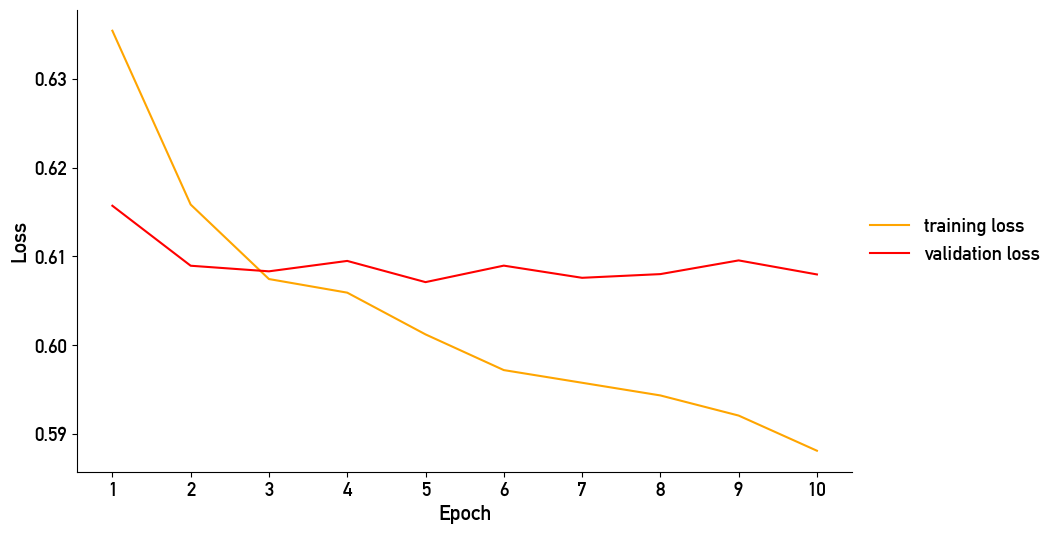

In [21]:
loss_path = os.path.join(multimodal_path, "model_outputs", "selection", "losses")
visualize_losses(model_name, loss_path)

### Loading the trained model

In [23]:
# load the trained raster models
raster_model_path = os.path.join(raster_path, "models", "selection")

#raster_model_name = ""
raster_model = CNN(n_channels=3, n_classes=4)
raster_checkpoint = torch.load(os.path.join(raster_model_path, raster_model_name), map_location=device)
raster_model.load_state_dict(raster_checkpoint["model_state_dict"])
raster_model.eval()

# load the trained vector models
vector_model_path = os.path.join(vector_path, "models", "selection")

#vector_model_name = ""
vector_model = initialize_gnn(model="hgt", 
                              sample=dummy_sample, 
                              hidden_channels=128, 
                              num_heads=8,
                              num_layers=3, 
                              node_to_predict="focal_building")
vector_checkpoint = torch.load(os.path.join(vector_model_path, vector_model_name), map_location=device)
vector_model.load_state_dict(vector_checkpoint["model_state_dict"])
vector_model.eval()

# load the trained multimodal model
model_path = os.path.join(multimodal_path, "models", "selection")

#model_name = ""
model = MultimodalModel(raster_model=raster_model, 
                        vector_model=vector_model, 
                        dummy_raster_sample=training_set[1][0], 
                        dummy_vector_sample=dummy_sample, 
                        n_classes=4)
checkpoint = torch.load(os.path.join(model_path, model_name), map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print("Model successfully loaded.")

Number of node features: {'focal_building': 10, 'context_building': 10, 'road': 2}, 4 operators
Model successfully loaded.


### ROC and PR curves

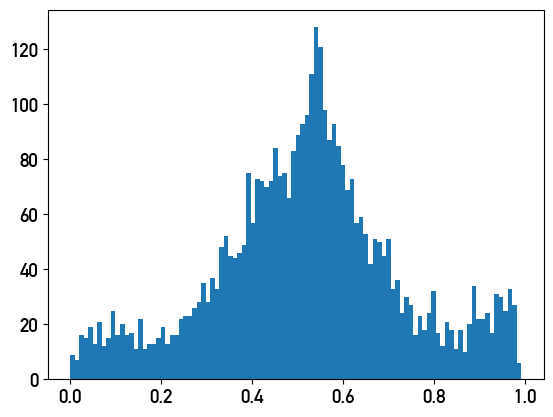

In [24]:
activations = get_activations_multimodal(model, 
                                         dataset=validation_set, 
                                         batch_size=len(validation_set), 
                                         operators_to_pred=selection_operators, 
                                         device=device)

plt.hist(activations, bins=100)
plt.show()

In [25]:
# get precision-recall and ROC values for different thresholds
pr_roc = get_pr_roc(model=model, 
                    dataset=validation_set, 
                    batch_size=len(validation_set), 
                    operators_to_pred=selection_operators, 
                    device=device, 
                    interval=(0,1), 
                    increment=0.1)

# save the PR and ROC values
model_name = get_model_name(model, 
                            ops="sel", 
                            attach_roads=True, 
                            n_samples=len(training_set), 
                            n_epochs=n_epochs, 
                            batch_size=batch_size,
                            device=device) + ".csv"
pr_roc_path = os.path.join(multimodal_path, "model_outputs", "selection", "pr_roc", model_name)
pr_roc.to_csv(pr_roc_path, index=False)

/Library/anaconda3/envs/genops/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/anaconda3/envs/genops/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/anaconda3/envs/genops/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


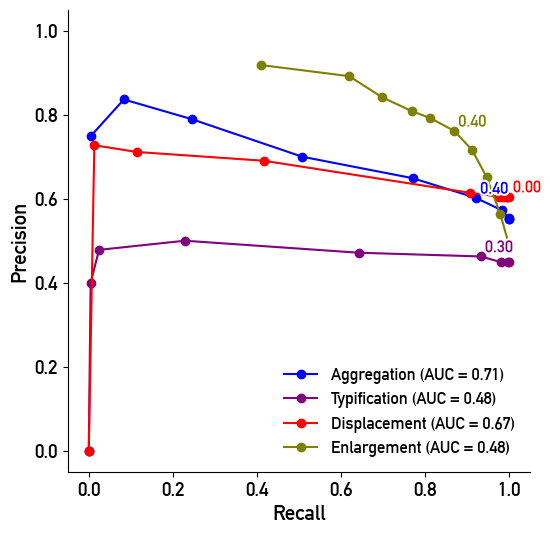

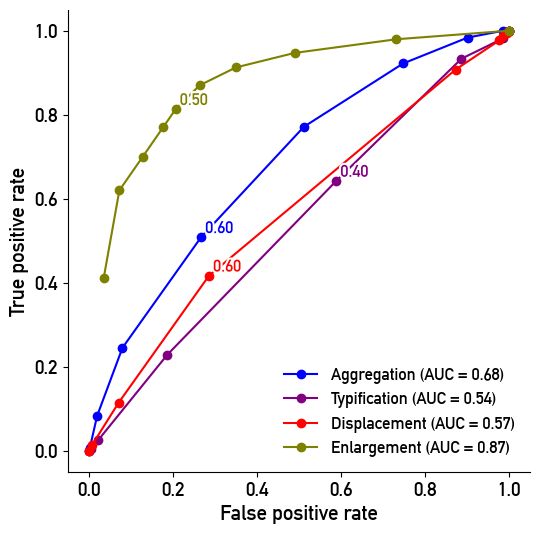

In [26]:
# plot the curves
plot_pr_curve([pr_roc_path], threshold_labels=True)
plot_roc_curve([pr_roc_path], threshold_labels=True)

### Accuracy metrics

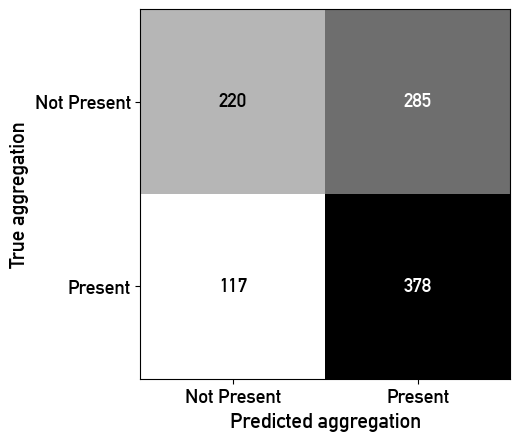

Accuracy: 0.598
Precision: 0.570
Recall: 0.764
F1 Score: 0.653


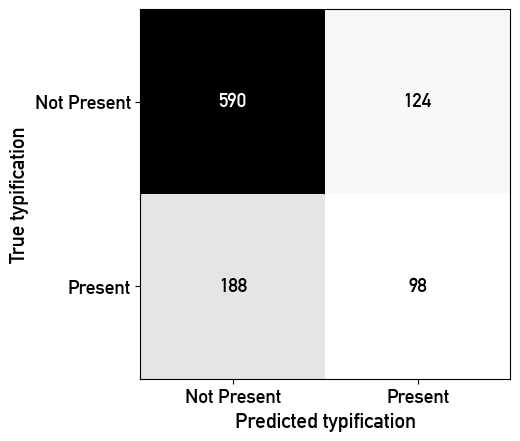

Accuracy: 0.688
Precision: 0.441
Recall: 0.343
F1 Score: 0.386


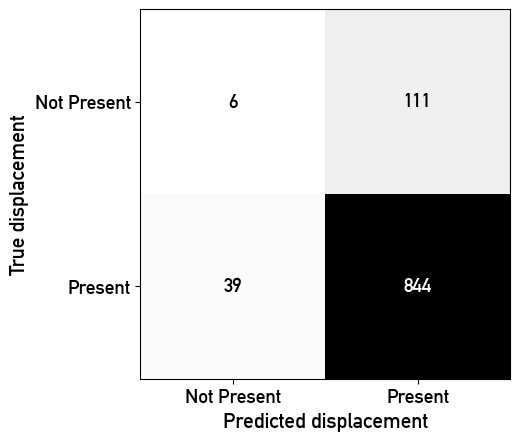

Accuracy: 0.850
Precision: 0.884
Recall: 0.956
F1 Score: 0.918


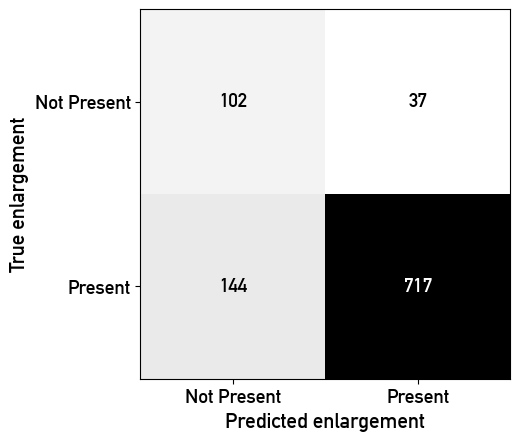

Accuracy: 0.819
Precision: 0.951
Recall: 0.833
F1 Score: 0.888


In [27]:
# calculate accuracy metrics
metrics = get_metrics_multimodal(model=model, 
                                 dataset=test_set,
                                 batch_size=len(test_set),
                                 operators_to_pred=selection_operators, 
                                 threshold=0.5, 
                                 device=device)

# saving the accuracy metrics
model_name = get_model_name(model, 
                            ops="sel", 
                            attach_roads=True, 
                            n_samples=len(training_set), 
                            n_epochs=n_epochs, 
                            batch_size=batch_size,
                            device=device) + ".csv"
metrics_path = os.path.join(multimodal_path, "model_outputs", "selection", "metrics", model_name)

# creating a DataFrame with accuracy metrics
metrics_df = pd.DataFrame({"operator": metrics["operator"],
                           "accuracy": metrics["accuracy"], 
                           "precision": metrics["precision"],
                           "recall": metrics["recall"],
                           "f1-score": metrics["f1_score"]})

# save to CSV
metrics_df.to_csv(metrics_path, index=False)

# print the results
for i in range(len(selection_operators)):
    # display the confusion matrix
    visualize_confusion_matrix(metrics["conf_matrix"][i], operator=metrics["operator"][i])

    # print metrics
    print(f"Accuracy: {metrics['accuracy'][i]:.3f}")
    print(f"Precision: {metrics['precision'][i]:.3f}")
    print(f"Recall: {metrics['recall'][i]:.3f}")
    print(f"F1 Score: {metrics['f1_score'][i]:.3f}")

## Loss curves of multimodal models

In [ ]:
# loss path
model_losses = []

visualize_multiple_losses(model_losses, 
                          path_to_data="../data.nosync", 
                          model="multimodal", 
                          figsize=(6,5), 
                          save=True, 
                          output_path="../../Figures/Results/losses")